## Sensitivity Analysis for Sumo model
### Steps followed
1. Import the necessary libraries to the notebook
2. Initialize and load the Sumo model by providing the path and license file
3. Define and setup the input factors
4. Conduct the sensitivity analysis
5. Post processing and screening of influential factors

### Import libraries

In [1]:
from dynamita.sumo import *
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import stats   

In [2]:
from SALib.sample import morris
from SALib.analyze import morris as mr
import random

In [18]:
%matplotlib inline

### Initialize and load the Sumo model

In [4]:
sumo = Sumo(sumoPath="C:/Users/zeru/AppData/Local/Dynamita/Sumo16", licenseFile=r"networklicense.sumolic")

License OK...


In [5]:
def datacomm_callback(sumo):
    t.append(sumo.core.csumo_var_get_time_double(sumo.handle))
    #snhx.append(sumo.core.csumo_var_get_pvtarray_pos(sumo.handle, snhx_pos, 0))
    for i in range(6):
        snhx[i].append(sumo.core.csumo_var_get_pvtarray_pos(sumo.handle, snhx_pos, i))
    return 0

In [6]:
sumo.unload_model()
if not sumo.load_model('myGSBR.sumo'):
    print ('Model successfuly loaded!')

No model is loaded
Model successfuly loaded!


In [102]:
sumo.register_datacomm_callback(datacomm_callback)

In [103]:
snhx_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__GranularSBR__SNHx')
sumo.core.csumo_command_send(sumo.handle, b'execute script_Initialize.scs;')
snhx_pos

86

### Test run the Sumo model

In [104]:
%%time 
stop_t=6*3600*1000
dataComm = 180000
sumo.set_stopTime(stop_t)
sumo.set_dataComm(dataComm)
t = []
snhx=[[] for i in range(6)]

sumo.run_model()

while not sumo.simulation_finished:
        time.sleep(0.01)

Wall time: 11.1 s


In [101]:
print(len(t))
stop_t/dataComm

121


120.0

In [11]:
titles=["Bulk", "Layer 1", "Layer 2", "Layer 3", "Layer 4", "Layer 5"]
data_dict = dict(zip(titles,snhx))
dframe = pd.DataFrame(data_dict, index=t)

In [ ]:
dframe.head(20)

In [ ]:
dframe.plot()

### Start setting up the sensitivity analysis
#### Start with defining the input factors and their range
21 input factors have been selected to conduct the sensitivity analysis.

In [170]:
%%time
# Start Sensitivity analysis
# Define the model inputs
problem = {
    'num_vars': 23,
    'names': ['KO2_AOB', 'KNHx_AOB', 'mue_AOB', 'b_AOB', 'Y_AOB', 'KO2_NOB', 'KNO2_NOB', 'mue_NOB', 'b_NOB', 'Y_NOB', 'KNHx_ANX', 'KNO2_ANX', 'mue_ANX', 'b_ANX', 'Y_ANX_NO2', 'Y_ANX_NO3', 'KO2_OHO', 'KNO2_OHO','KNO3_OHO', 'mue_OHO', 'b_OHO', 'Y_OHO_ox', 'Y_OHO_anox'],
    'bounds': [[0.1, 3], [0.1, 5], [0.2, 2], [0.01, 0.5], [0.03, 0.3], [0.1, 6], [0.1, 8], [0.1, 5], [0.1, 5], [0.03, 0.3], [0.1, 3], [0.1, 2], [0.01, 0.5], [0.001, 0.05], [0.03, 0.3], [0.03, 0.3], [0.05, 0.5], [0.1, 1], [0.1, 1], [0.1, 8], [0.01, 0.5], [0.1, 0.99],[0.1, 0.99]]
}

# Generate samples
param_values = morris.sample(problem, 30, num_levels=10, grid_jump=4) #optimal_trajectories= 60)

# Si = morris.analyze(problem, X, Y, conf_level=0.95, print_to_console=True, num_levels=4, grid_jump=2)

Wall time: 19.1 ms


In [171]:
param_values.shape

(720, 23)

### Plot the sample parameters 
The generated samples of the 21 input factors histogram is ploted below. This will help us to visualize how well the samples have been selected from the input space. We should expect approximately a uniform distribution otherwise we have to  re-generate the samples above until we are satisfied.

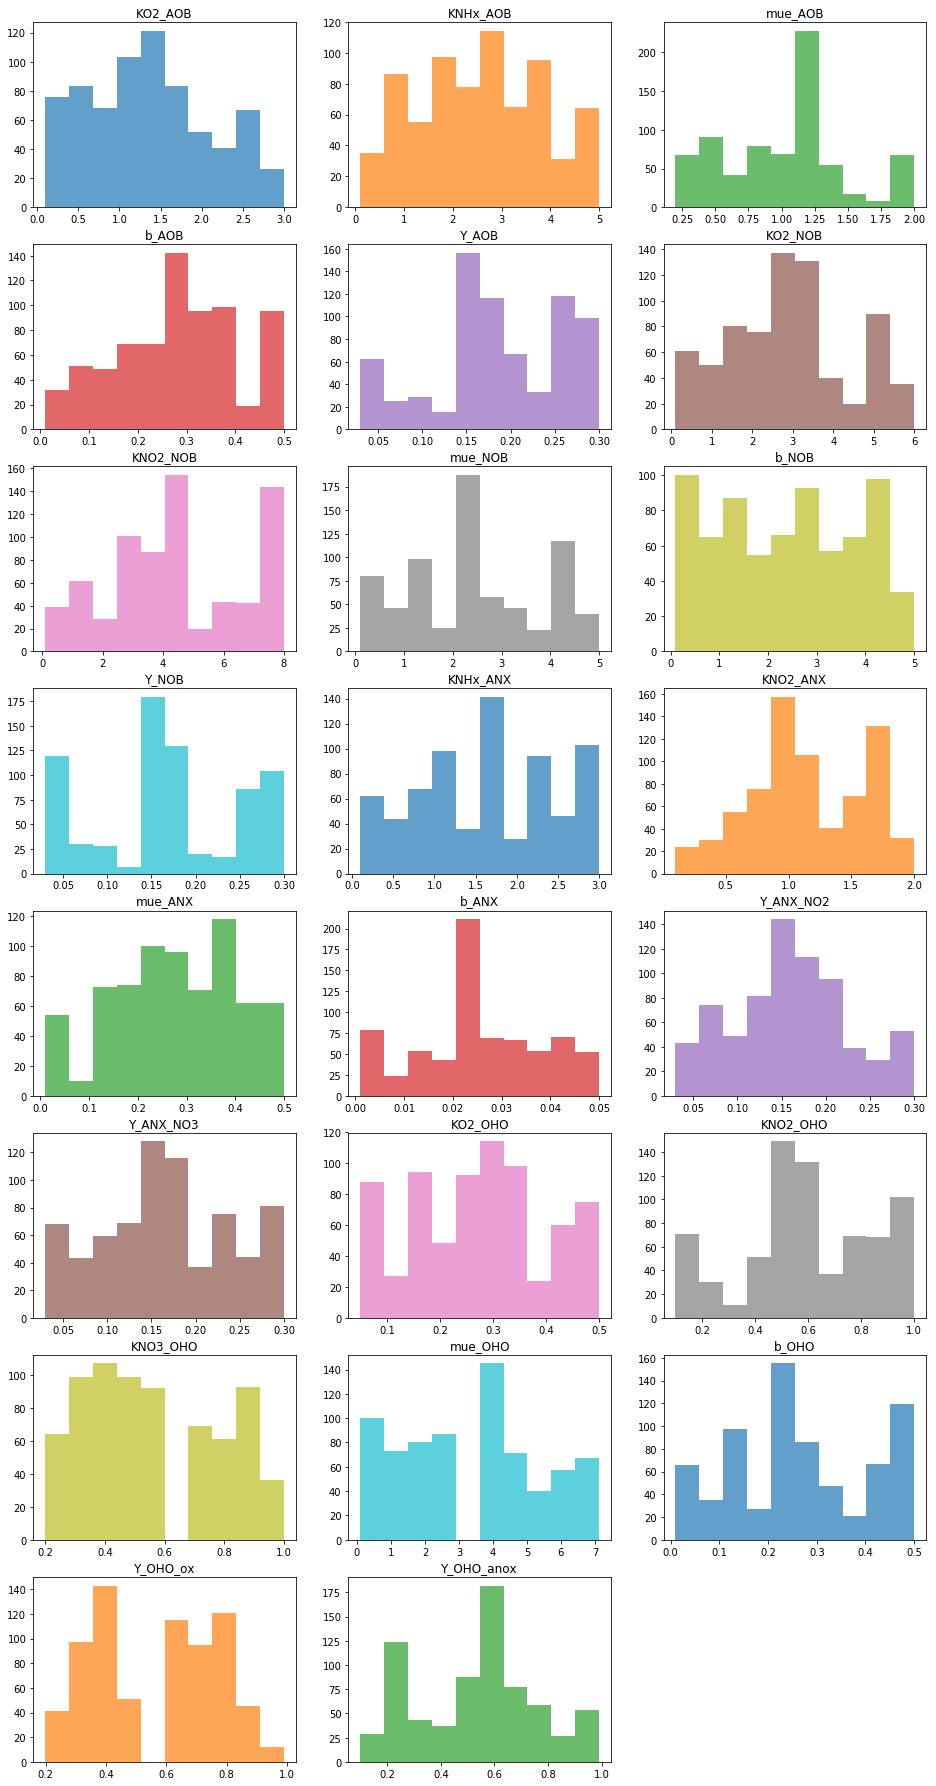

In [172]:
#selected_p=random.sample(param_values[:, 0].tolist(),3)
plt.figure(figsize=(16, 32))
cc=('C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C0', 'C1','C2')
for i in range(23):
    plt.subplot(8,3,i+1)
    plt.hist(param_values[:,i], histtype='stepfilled', alpha=0.7, color=cc[i] , bins=10)
    plt.title(problem['names'][i])

In [ ]:
param_values[0:5,:]

In [209]:
def converter(x): return ''.join(str(e) for e in 6*list(' '+ str(x)))
print(''.join(str(e) for e in 6*list(' '+ str(6.77))))
    
converter(4.5)
y=''.join(str(e) for e in 6*list(' '+ str(5.4)))
print(y)

 6.77 6.77 6.77 6.77 6.77 6.77
 5.4 5.4 5.4 5.4 5.4 5.4


### Start the sensitivity analysis

In [ ]:
%%time
# Let's store all the sensitivity analysis results in one data structure.

from collections import OrderedDict
snhx_sensitivity_data = OrderedDict()

t_out=int(stop_t/dataComm)
iteration=param_values.shape[0]
for i in range(20):
    k=random.randint(0,719)
    command = 'set Sumo__Plant__GranularSBR__KO2_AOB ' + str(param_values[i,0]) + ';'+ \
                'set Sumo__Plant__GRanularSBR__KNHx_AOB ' + str(param_values[i,1]) + ';'+ \
                'set Sumo__Plant__GRanularSBR__MuAOB_T ' + str(param_values[i,1]) + ';'+ \
                'set Sumo__Plant__GRanularSBR__bAOB_T ' + str(param_values[i,1]) + ';'+ \
                'set Sumo__Plant__GRanularSBR__Sumo2__YAOB ' + str(param_values[i,1]) + ';'+ \
                'set Sumo__Plant__GranularSBR__KO2_NOB ' + str(param_values[i,0]) + ';'+ \
                'set Sumo__Plant__GRanularSBR__KNO2_NOB ' + str(param_values[i,1]) + ';'+ \
                'set Sumo__Plant__GRanularSBR__MuNOB_T ' + str(param_values[i,1]) + ';'+ \
                'set Sumo__Plant__GRanularSBR__bNOB_T ' + str(param_values[i,1]) + ';'+ \
                'set Sumo__Plant__GRanularSBR__Sumo2__YNOB ' + str(param_values[i,1]) + ';'+ \
                'set Sumo__Plant__GRanularSBR__KNHx_AMX ' + str(param_values[i,1]) + ';'+ \
                'set Sumo__Plant__GranularSBR__KNO2_AMX ' + str(param_values[i,0]) + ';'+ \
                'set Sumo__Plant__GRanularSBR__MuAMX_T ' + str(param_values[i,1]) + ';'+ \
                'set Sumo__Plant__GRanularSBR__bAMX_T ' + str(param_values[i,1]) + ';'+ \
                'set Sumo__Plant__GRanularSBR__Sumo2__YAMX_NO2 ' + str(param_values[i,1]) + ';'+ \
                'set Sumo__Plant__GRanularSBR__Sumo2__YAMX_NO3 ' + str(param_values[i,1]) + ';'+ \
                'set Sumo__Plant__GranularSBR__KO2_OHO ' + str(param_values[i,0]) + ';'+ \
                'set Sumo__Plant__GranularSBR__KNO2_OHO ' + str(param_values[i,0]) + ';'+ \
                'set Sumo__Plant__GranularSBR__KNO3_OHO ' + str(param_values[i,0]) + ';'+ \
                'set Sumo__Plant__GRanularSBR__MuOHO_T ' + str(param_values[i,1]) + ';'+ \
                'set Sumo__Plant__GRanularSBR__bOHO_T ' + str(param_values[i,1]) + ';'+ \               
                'set Sumo__Plant__GRanularSBR__Sumo2__YOHO_VFA_ox ' + str(param_values[i,1]) + ';' \
                'set Sumo__Plant__GRanularSBR__Sumo2__YOHO_VFA_anox ' + str(param_values[i,1]) + ';'
                
                
    sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))
    
    print ('Iteration ', i)
    # Do not forget to empty our lists before a simulation, otherwise
    # new simulation results would just be appended.
    t = []
    snhx=[[] for i in range(6)]
    
    # Let's have Sumo do some work
    sumo.run_model()
    # The run_model is an asynchronous call, so we need to wait until
    # the current run is finished, otherwise we would mess up our simulations
    while not sumo.simulation_finished:
        time.sleep(0.01)

    # Good, we got our data in the list, let's store 'em in our dictionary, using 
    # KNHx as the label
    
    snhx_sensitivity_data[i] = snhx[:t_out]

In [ ]:
param_values[:5,:]

In [55]:
my_list=[[1,2,5,5],[3,4,6,5],[5,7,8,9,9]]
min(len(x)  for x in my_list)

4

In [211]:
#key=str(selected_p[0])
sens_list=list(snhx_sensitivity_data.values())
print(min(len(x) for x in sens_list))
sens_array=np.array(sens_list)
#print (snhx_sensitivity_data.keys())
#print(selected_p)
print ("array dim ", sens_array.ndim)
print ("array shape ", sens_array.shape)
#plt.plot(t, sens_array[:,0,:].T)
#plt.legend(loc="bottom middle")

6
array dim  3
array shape  (300, 6, 121)


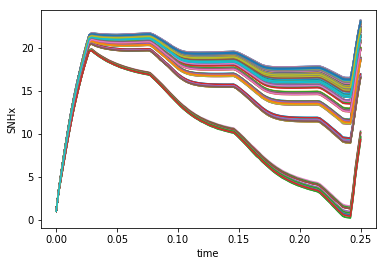

In [210]:
fig,ax=plt.subplots(1,1)
ax.set_xlabel('time')
ax.set_ylabel('SNHx')
titles=("Bulk", "Layer 1", "Layer 2", "Layer 3", "Layer 4", "Layer 5")
markers=('_','x','o','^')
y_list=[]
for k, v in snhx_sensitivity_data.items():
    
    ax.plot(t, v[0], label=str(k))
    y_list.append(v[0])
    #plt.show()
    #fig.canvas.draw()

#plt.legend(loc='upper right', title='Legend')


In [ ]:
X=np.array(list(snhx_sensitivity_data.keys()))
Y=np.array(y_list)
corr=[]
#np.corrcoef(X,Y[:,-1])
for i in range(Y.shape[1]):
    corr.append(stats.pearsonr(X,Y[:,i])[0])
    


In [199]:
plt.plot(t, corr, 'ro')
plt.show()

In [77]:
Si=[]
Si_list_dict=[]
X=param_values
print("X size ", X.shape)
print(sens_array.shape[0]-1)
Si_ndarray=np.empty([4,2,121])
for i in range(sens_array.shape[2]-1):
    Y=sens_array[:,0,i]
    Si_out=mr.analyze(problem, X, Y, conf_level=0.95, print_to_console=False, num_levels=10, grid_jump=2)   
    Si_list_dict.append(Si_out)
    Si_list=list(Si_out.values())
    Si_array=np.array(Si_list)
    Si.append(Si_list)
    Si_ndarray[:,:,i]=Si_array[1:,:,]
    

X size  (300, 2)
299


In [83]:
Si_out.keys()

dict_keys(['names', 'mu', 'mu_star', 'sigma', 'mu_star_conf'])

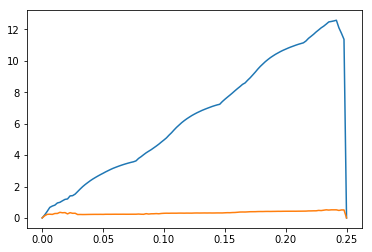

In [98]:
plt.plot(t,Si_ndarray[1,0,:])
plt.plot(t,Si_ndarray[1,1,:])